# Import Packages

In [1]:
#!pip install seaborn livelossplot torchsummary torchmetrics

import os
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.style.use('ggplot')
from livelossplot import PlotLosses

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary as summary_
import torchvision as tv
from torchvision.transforms import ToTensor
import torchmetrics as tm

def set_random_seed_torch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42    
set_random_seed_torch(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Load dataset

In [2]:
train_data = tv.datasets.MNIST(root='data', download=True, train=True, transform=ToTensor())
test_data  = tv.datasets.MNIST(root='data', download=True, train=False, transform=ToTensor())

X_train, y_train = train_data.data, train_data.targets
X_test,  y_test  = test_data.data,  test_data.targets
X_train.shape, y_train.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

# 2. Preprocessing

In [3]:
X_train, X_test = X_train / 255, X_test / 255
X_train = X_train.unsqueeze(1).float()  # (B, H, W) -> (B, C, H, W)
X_test  = X_test.unsqueeze(1).float()

In [4]:
INPUT_SHAPE  = X_train[0].shape
OUTPUT_SHAPE = 1
N_CLASSES    = len(y_train.unique())

print("- Training(X, y):", X_train.shape, y_train.shape)
print("- Test(X, y):", X_test.shape, y_test.shape)
print("- Number of classes:", N_CLASSES)

- Training(X, y): torch.Size([60000, 1, 28, 28]) torch.Size([60000])
- Test(X, y): torch.Size([10000, 1, 28, 28]) torch.Size([10000])
- Number of classes: 10


In [5]:
def generate_dataloader_torch(X, y=None, batch_size=32, shuffle=True):
    """Generate TensorFlow dataset from array-like data (X, y)

    Parameters
    ----------
    X : array-like
        Input data

    y : numpy.ndarray (default=None)
        Output data

    batch_size : int (default=32)
        Batch size

    shuffle : bool (default=True)
        Whether to shuffle data

    Returns
    -------
    PyTorch dataloader : torch.utils.data.DataLoader
        Generated dataloader
    """
    from torch.utils.data import Dataset, DataLoader
    
    class CustomDataset(Dataset):
        def __init__(self, X, y=None):
            self.X = torch.tensor(X, device=device)
            if y is None:
                y = torch.zeros(len(self.X), device=device)  # dummy
            self.y = torch.tensor(y, device=device, dtype=torch.long)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    # 1. Generate dataset
    X = np.array(X, dtype=np.float32)
    if y is not None:
        y = np.array(y, dtype=np.float32)
        ds = CustomDataset(X, y)
    else:
        ds = CustomDataset(X)

    # 2. Generate dataloader
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_dl = generate_dataloader_torch(X_train, y_train)
test_dl  = generate_dataloader_torch(X_test, y_test)

# 3. Modeling

In [6]:
FILTERS     = 32
KERNEL_SIZE = 3
UNITS       = 128

model = nn.Sequential(
    nn.LazyConv2d(FILTERS, KERNEL_SIZE),
    nn.ReLU(),
    nn.Flatten(),
    nn.LazyLinear(UNITS),
    nn.ReLU(),
    nn.LazyLinear(N_CLASSES)
).to(device)

criterion = nn.CrossEntropyLoss()
get_acc   = tm.Accuracy(task='multiclass', num_classes=N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters())

# model.summary()

/opt/conda/envs/tf_torch/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# 4. Training

In [7]:
def train_step(images, labels):
    probs = model(images)
    loss = criterion(probs, labels)
    acc  = get_acc(probs.argmax(1), labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, acc
    
def test_step(images, labels):
    probs = model(images)
    loss = criterion(probs, labels)
    acc  = get_acc(probs.argmax(1), labels)
    return loss, acc

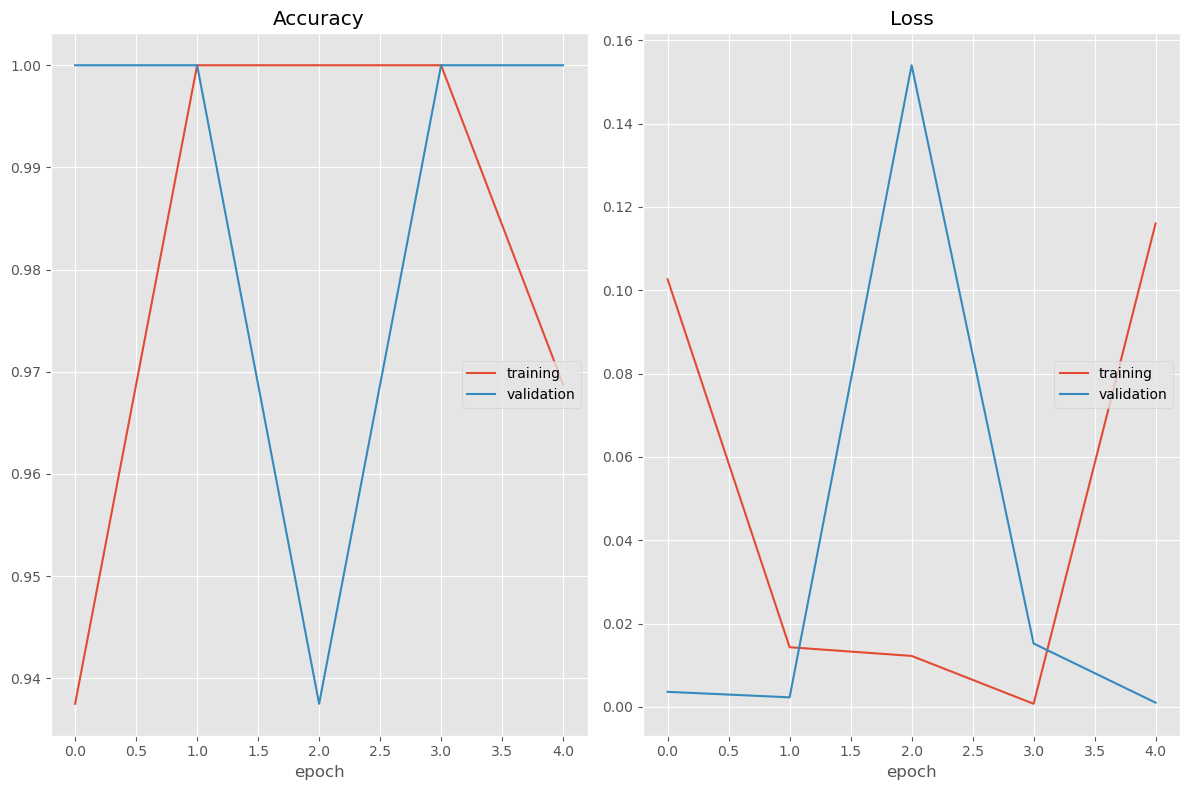

100%|██████████| 5/5 [00:46<00:00,  9.22s/it]

Accuracy
	training         	 (min:    0.938, max:    1.000, cur:    0.969)
	validation       	 (min:    0.938, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.001, max:    0.116, cur:    0.116)
	validation       	 (min:    0.001, max:    0.154, cur:    0.001)


In [8]:
EPOCHS = 5
liveloss = PlotLosses()

rst = pd.DataFrame(columns=['loss', 'acc', 'val_loss', 'val_acc'], index=pd.Index([], name='Epoch'))
for epoch in tqdm(range(1, EPOCHS+1)):
    for images, labels in train_dl:
        loss, acc = train_step(images, labels)

    with torch.no_grad():
        for test_images, test_labels in test_dl:
            val_loss, val_acc = test_step(test_images, test_labels)
    
    rst.loc[epoch] = list(map(float, [loss, acc, val_loss, val_acc]))
    liveloss.update(rst.loc[epoch])
    liveloss.send()